# Рекомендация тарифов мобильного оператора


**Общая цель:** построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».


**Цели исследования:** построить модель для задачи классификации, которая выберет подходящий тариф. Модель должна быть с максимально большим значением accuracy, необходимая доля правильных ответов не меньше 0.75.


**План работы:** 
1. Провести выгрузку данных, изучить общую информацию
2. Разделить исходные данные на обучающую, валидационную и тестовую выборки.
3. Исследовать качество разных моделей, меняя гиперпараметры. Подготовить краткие выводы исследования.
4. Проверить качество модели на тестовой выборке.
5. Проверить модели на вменяемость.
6. Подготовить общий вывод


**Описание данных:** Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

Предобработка данных уже проведена.

## Откроем и изучим файл

Подключим необходимые модули и библиотеки

In [1]:
import time

import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import tree
import matplotlib.pyplot as plt

Загрузим файл

In [2]:
try:
    df = pd.read_csv('users_behavior.csv')
except:
    df = pd.read_csv('https:..')

Изучим информацию о файле

In [3]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [5]:
df.isna().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

In [6]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Проведём проверку на сбалансированность классов по целевому признаку.

In [7]:
df['is_ultra'].value_counts()/df.shape[0]*100

is_ultra
0    69.352831
1    30.647169
Name: count, dtype: float64

*Количество пользователей с тарифом "Смарт"(69%) больше, чем с тарифом "Ультра"(31%).*

Изучим датафрейм на корреляцию признаков

In [8]:
df.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


*Сильная корреляция наблюдается между двумя признаками: 'minuetes' и 'calls'. Говорить о мультиколлинеарности не приходится.*

**Вывод:** проведена загрузка ключевых модулей файла, проведен обзор информации.

## Разобьём данные на выборки

Определим обучающий набор данных(*features*) и целевой признак(*target*).

In [9]:
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

*Целевой признак target категориальный, должна решаться задача классификации.*

Разделим набор данных на обучающий(60%), валидационный(20%) и тестовый(20%), по правилу 3:1:1.
Для начала получим тестовый и **обучающий набор**.

In [10]:
features_train, features_test, target_train, target_test =\
train_test_split(features, target, test_size=0.4, random_state=12345)
features_test.shape

(1286, 4)

Перезапишем пременные и получим **тестовый и валидационный** набор. 

In [11]:
features_test, features_valid, target_test, target_valid =\
train_test_split(features_test, target_test, test_size=.5, random_state=12345)
print('Размер выборки:')
print(f'- обучающей — {features_train.shape[0]}')
print(f'- валидационной — {features_valid.shape[0]}')
print(f'- тестовой — {features_test.shape[0]}')

Размер выборки:
- обучающей — 1928
- валидационной — 643
- тестовой — 643


**Вывод:** проведено определение обучающего набора данных(*features*) и целевого признака(*target*). Разделен набор данных на:
- features_train, target_train — обучающий(60%);
- features_valid, target_valid — валидационный(20%);
- features_test, target_test — тестовый(20%).

## Исследуем модели

Так как целевой признак *target* категориальный, будет решаться задача классификации. Проведём исследование качества разных моделей.

### Модель DecisionTreeClassifier

Проведём эксперимент для выявления лучших гиперпараметров модели. Определим значения используя валидационную выборку. Будем использовать гиперпараметры:
- random_state — управляет случайностью оценки;
- max_depth — максимальная глубина дерева;
- splitter — стратегия, используемая для выбора разделения на каждом узле;
- min_samples_split — минимальное количество выборок, необходимое для разделения внутреннего узла;
- min_samples_leaf — минимальное количество выборок, необходимых для нахождения в конечном узле.

In [12]:
best_model_dtc = None
best_result_dtc = 0
top_depth_dtc = 1
for el in ['random', 'best']:
    for spl in range(2,6):
        for depth in range(1, 21):
            # Определение гиперпараметров модели
            model = DecisionTreeClassifier(random_state=12345, max_depth=depth, splitter=el,
                                           min_samples_split=spl, min_samples_leaf=spl-1) 
            # обучение модели
            model.fit(features_train, target_train) 
            # предсказания модели на валидационной выборке
            predictions = model.predict(features_valid) 
            # нахождение качества модели для валидационной выборки
            result = accuracy_score(target_valid, predictions)
            if result > best_result_dtc:
                best_model_dtc = model
                best_result_dtc = result
                
                top_depth_dtc = depth
                top_splitter_dtc = el
                top_split = spl
                top_leaf = spl-1
                
print('Оптимальная глубина дерева:', top_depth_dtc)
print('Стратегия разделения:', top_splitter_dtc)
print('\nОптимальное количество выборок, необходимое для:')
print('- разделения внутреннего узла:', top_split)
print('- размещения в конечном узле:', top_leaf)

Оптимальная глубина дерева: 11
Стратегия разделения: random

Оптимальное количество выборок, необходимое для:
- разделения внутреннего узла: 5
- размещения в конечном узле: 4


Изучим, как модель принимает решение. Построим график `plot_tree`

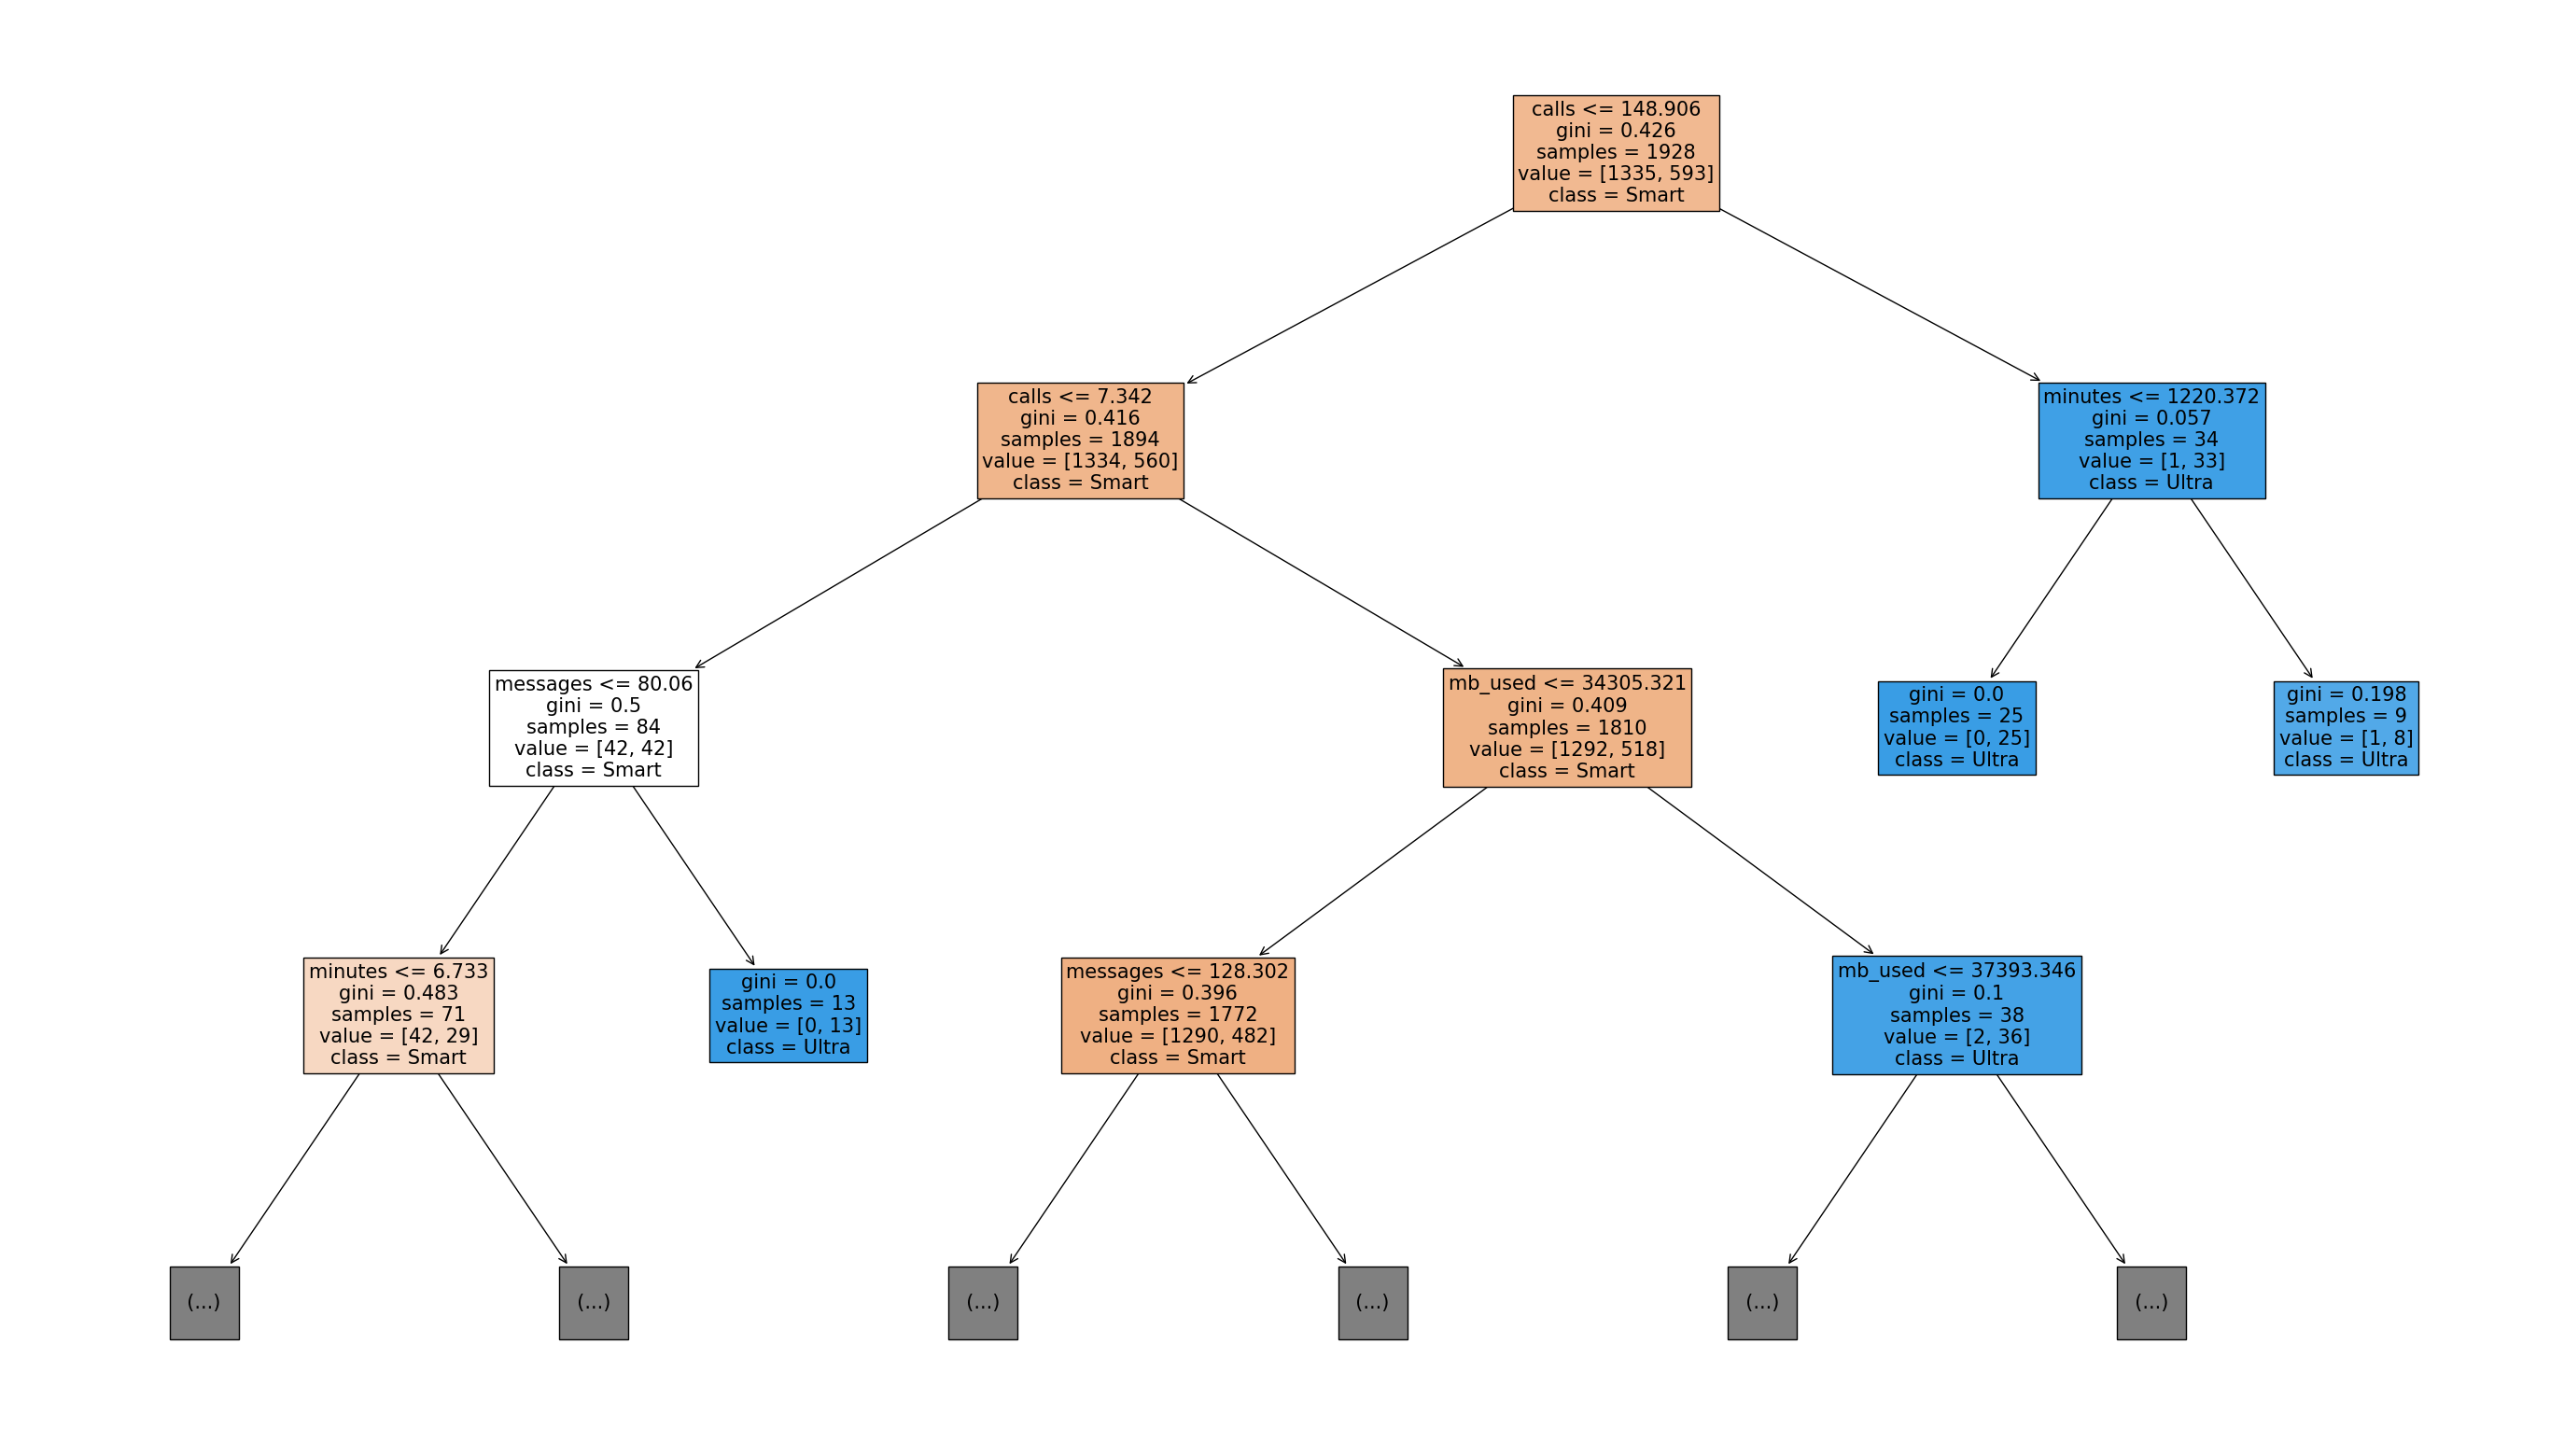

In [13]:
def nice_visualisation(var):
    clf = tree.DecisionTreeClassifier(random_state=12345,
                                      splitter=top_splitter_dtc,
                                      min_samples_split=top_split,
                                      min_samples_leaf=top_leaf,
                                      max_depth=var)
    clf = clf.fit(features_train, target_train)
    fig = plt.figure(figsize=(35,20))
    tree.plot_tree(clf,
                   feature_names=features.columns.values, 
                   class_names=['Smart','Ultra'],
                   filled=True,
                   fontsize = 15,
                   max_depth = 3     # Это чтобы прорисовывало 3 уровня, не глубже
                      );
    
nice_visualisation(4)    

Проведём эксперимент, визуализируем график распределения точности между значениями выборок train и valid, меняя при этом depth. Большая разность в точности между выборками будет свидетельствовать о переобучении модели.

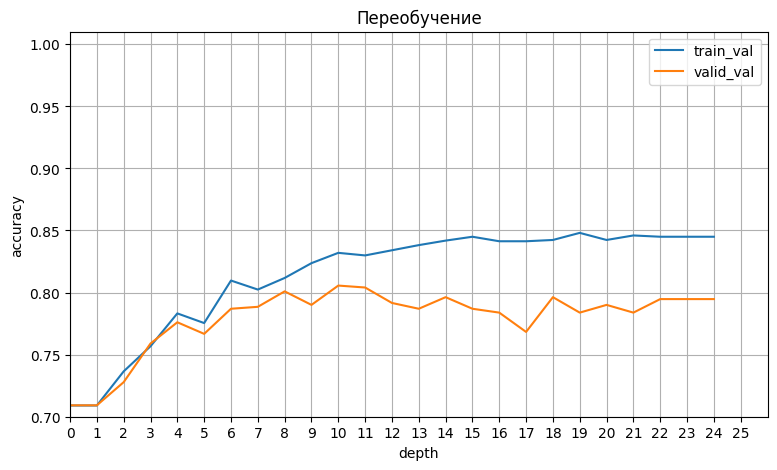

In [14]:
def mod_acc(height):
    score_t = []
    score_v = []
    for depth in range(1,height):
        model = DecisionTreeClassifier(random_state=12345,
                                       max_depth=depth,
                                       splitter=top_splitter_dtc,
                                       min_samples_split=top_split,
                                       min_samples_leaf=top_leaf) 
        # обучение модели
        model.fit(features_train, target_train) 

        # для обучающей выборки
        predictions = model.predict(features_train) 
        result_train = accuracy_score(target_train, predictions)

        # для валидационной выборки
        predictions = model.predict(features_valid) 
        result_valid = accuracy_score(target_valid, predictions)

        # Сохранение результатов
        score_t.append(result_train)
        score_v.append(result_valid)
    
    
    plt.figure(figsize=(9, 5))
    plt.plot(score_t, label='train_val')
    plt.plot(score_v, label='valid_val')
    plt.grid()
    plt.axis([0,height,0.7,1.01])
    plt.legend()
    plt.xlabel('depth')
    plt.ylabel('accuracy')
    plt.title('Переобучение')
    plt.xticks(range(0,26,1))

mod_acc(26)    

*Как видно, начало переобучения модели можно наблюдать на глубине выше 3,5.*

Проведём проверку скорости работы предсказания модели.

In [15]:
start = time.time()
predictions_dtc = best_model_dtc.predict(features_test)
end = time.time()
time_dtc = (end-start) * 10**3

Определим функцию для вывода, чтобы не повторяться

In [16]:
def conc(accuracy, time):
    print('Доля правильных ответов модели'
          f' для валидационного набора данных:\n — {accuracy}')
    print('\nВремя предсказания модели:\n'
          f' — {time :.3} ms')

**Вывод:**

Подведём итог для выбранных гиперпараметров, выявленных с помощью обучающей и валидационной выборок.

In [17]:
conc(best_result_dtc, time_dtc)

Доля правильных ответов модели для валидационного набора данных:
 — 0.8055987558320373

Время предсказания модели:
 — 0.975 ms


### Модель RandomForestClassifier

Проведём эксперимент для выявления лучших гиперпараметров модели. Определим значения используя валидационную выборку.

In [18]:
best_model_rfc = None
best_result_rfc =  0
for est in range(1, 7):
    for depth in range(1, 11):
        for spl in range(2,5):
            for lf in range(1,4):
                model = RandomForestClassifier(random_state=12345,
                                               n_estimators=est,
                                               max_depth=depth,
                                               min_samples_split=spl,
                                               min_samples_leaf=lf)

                model.fit(features_train, target_train)
                answer = model.score(features_valid, target_valid)
                if answer > best_result_rfc:
                    best_result_rfc = answer
                    best_model_rfc = model
                    best_est_rfc = est
                    best_depth_rfc = depth
                    top_spl_rfc = spl
                    top_lf_rfc = lf
        
        
print('Оптимальное количество деревьев:', best_est_rfc)
print('Оптимальная глубина:', best_depth_rfc)
print('\nОптимальное количество выборок, необходимое для:')
print('- разделения внутреннего узла:', top_spl_rfc)
print('- размещения в конечном узле:', top_lf_rfc)

Оптимальное количество деревьев: 6
Оптимальная глубина: 10

Оптимальное количество выборок, необходимое для:
- разделения внутреннего узла: 2
- размещения в конечном узле: 3


Проведём эксперимент, визуализируем график распределения точности между значениями выборок train и valid, меняя при этом depth. Большая разность в точности между выборками будет свидетельствовать о переобучении модели.

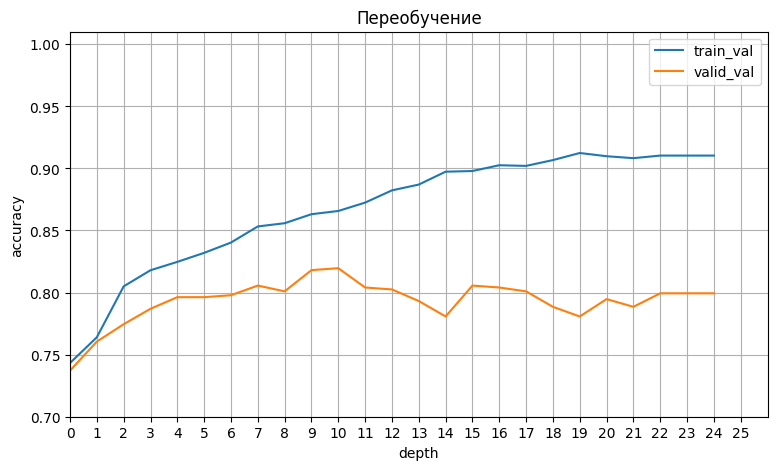

In [19]:
def mod_acc_rfc(height):
    score_t = []
    score_v = []
    for depth in range(1,height):
        model = RandomForestClassifier(random_state=12345,
                                       n_estimators=best_est_rfc,
                                       max_depth=depth,
                                       min_samples_split=top_spl_rfc,
                                       min_samples_leaf=top_lf_rfc) 
        # обучение модели
        model.fit(features_train, target_train) 

        # для обучающей выборки
        predictions = model.predict(features_train) 
        result_train = accuracy_score(target_train, predictions)

        # для валидационной выборки
        predictions = model.predict(features_valid) 
        result_valid = accuracy_score(target_valid, predictions)

        # Сохранение результатов
        score_t.append(result_train)
        score_v.append(result_valid)
    
    
    plt.figure(figsize=(9, 5))
    plt.plot(score_t, label='train_val')
    plt.plot(score_v, label='valid_val')
    plt.grid()
    plt.axis([0,height,0.7,1.01])
    plt.legend()
    plt.xlabel('depth')
    plt.ylabel('accuracy')
    plt.title('Переобучение')
    plt.xticks(range(0,26,1))

mod_acc_rfc(26)    

Проведём проверку скорости работы предсказания модели.

In [20]:
start = time.time()
predictions_rfc = best_model_rfc.predict(features_test)
end = time.time()
time_rfc = (end-start) * 10**3

**Вывод:**

Подведём итог для лучших гиперпараметров, выявленных с помощью обучающей, валидационной и тестовой выборок.

In [21]:
conc(best_result_rfc, time_rfc)

Доля правильных ответов модели для валидационного набора данных:
 — 0.8180404354587869

Время предсказания модели:
 — 2.97 ms


### Модель LogisticRegression

In [22]:
model = LogisticRegression(random_state=12345,
                           solver='lbfgs',
                           max_iter=1000)
model.fit(features_train, target_train)
answer_valid_lr = model.score(features_valid, target_valid)

Проведём проверку скорости работы предсказания модели.

In [23]:
start = time.time()
predictions_lr = model.predict(features_train)
end = time.time()
time_lr = (end-start) * 10**3

**Вывод:**

Подведём итог для лучших гиперпараметров, выявленных с помощью обучающей, валидационной и тестовой выборок.

In [24]:
conc(answer_valid_lr, time_lr)

Доля правильных ответов модели для валидационного набора данных:
 — 0.6842923794712286

Время предсказания модели:
 — 0.997 ms


### Заключение

**Вывод:** в результате исследования были получены следующие данные для модели:
1. Решающего леса:
 - точность: 0.8055987558320373
 
 
2. Случайного леса: 
 - точность: 0.8180404354587869
 
 
3. Логистическая регрессия:
 - точность: 0.6842923794712286
 
 
Как видно, лучшая точность, проверенная на валидационной выборке, оказывается у модели 'Случайный лес'.

## Проверка модели на тестовой выборке

Изучим точность предсказания выбранной модели с гиперпараметрами на тестовой выборке.

### Модель RandomForestClassifier

In [25]:
test_rfc = best_model_rfc.score(features_test, target_test)
print(f'Точность предсказания: {test_rfc}')

Точность предсказания: 0.7884914463452566


### Заключение

**Вывод:** модель 'Случайный лес' показала точность на тестовой выборке:
- 0.7884914463452566



## Проверка модели на адекватность

Чтобы проверить модель на  адекватность нужно сравнить качество нашей лучшей модели с качеством лучшей константной модели. Если качество нашей модели окажется хуже качества константной модели, то наша модель бесполезна. Константная модель - это модель, которая предсказывает одну и ту же константу для любого входа. И если говорить о задаче классификации, то лучшая константа - это метка наибольшего класса.

Для начала определим метку наибольшего класса.

In [26]:
df['is_ultra'].value_counts()/df.shape[0]

is_ultra
0    0.693528
1    0.306472
Name: count, dtype: float64

*Наибольшим классом оказался 0 - тариф 'Смарт'*

### Модель DummyClassifier

Зададим константную модель для DummyClassifier. Проведём обучение и предсказание модели, получим её точность.

In [27]:
model_dc = DummyClassifier(strategy='most_frequent', random_state=1)
# задаем константную модель, которая будет предсказывать по most_frequent - самый частый класс
model_dc.fit(features_train, target_train)
# тут модель смотри на самый частый класс в target_train - типо "обучение"
predictions_dc = model_dc.predict(features_test)
# проогнозирует везде самый частый класс в features_test
answer_dc = model_dc.score(features_test, target_test)
# подсчёт точности
print('Точность предсказание модели', answer_dc)

Точность предсказание модели 0.7060653188180405


Проведём проверку на адекватность  модели DecisionTreeClassifier сравнивания точность с моделью, полученной при помощи DummyClassifier.

In [28]:
if test_rfc > answer_dc:
    print('Модель адекватна')
else:
    print('Модель бесполезна')

Модель адекватна


### Заключение

**Вывод:** модель прошла проверку на адекватность.

## Общий вывод

Чтобы построить модель для задачи классификации, которая выберет подходящий тариф были выполнены действия:
1. проведена загрузка и изучение данных.
2. разбиты данные по пропорции 3:1:1  на выборки:
    - features_train, target_train — обучающий(60%);
    - features_valid, target_valid — валидационный(20%);
    - features_test, target_test — тестовый(20%).
    
    
3. Проведено исследование моделей:
    - DecisionTreeClassifier;
    - RandomForestClassifier;
    - LogisticRegression.
    
    Результат исследования, выявил, что наиболбшей точностью обладает модель RandomForestClassifier (0.8180404354587869).


4. Результат проверки на тестовом наборе данных выявил у модели RandomForestClassifier точность  0.789.
5. Проверка на адекватность показала, что модель RandomForestClassifier адекватна.   

В целом можно заключить, что нам удалось построить модель для задачи классификации, которая выберет подходящий тариф. Модель обладает необходимой долей правильных ответов не меньше 0.75.
